In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base = os.path.dirname(os.getcwd())
stats_path = os.path.join(base, 'csv files', 'For_Stats.csv')

stats_df = pd.read_csv(stats_path)

In [3]:
judges_higher = (stats_df.groupby('judge_name')['goe_dist'].mean().sort_values(ascending=False).head(10))
judges_higher


judge_name
Patricia MORITZ     0.605322
Patty KLEIN         0.384196
Karin EHRHARDT      0.347382
Elizabeth RYAN      0.331719
Soo Kyung LEE       0.331034
Veronique VERRUE    0.328975
Senem AHISKAL       0.297650
Slobodan DELIC      0.292398
Samuel AUXIER       0.277533
Pekka LESKINEN      0.275676
Name: goe_dist, dtype: float64

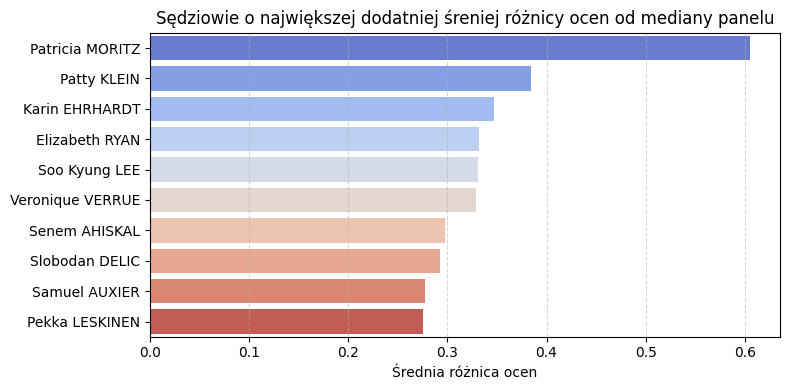

In [17]:
plt.figure(figsize=(8, 4))
sns.barplot(x=judges_higher.values, y=judges_higher.index, palette='coolwarm', hue=judges_higher.index)

plt.title('Sędziowie o największej dodatniej śreniej różnicy ocen od mediany panelu')
plt.ylabel('')
plt.xlabel('Średnia różnica ocen')

plt.tight_layout()
plt.grid(axis='x',  linestyle='--', alpha=0.5)
plt.show()

In [5]:
judges_lower = stats_df.groupby('judge_name')['goe_dist'].mean().sort_values(ascending=True).head(10)
judges_lower

judge_name
Jia YAO            -0.474097
Leslie KEEN        -0.443359
Lisa DAVIDSON      -0.430884
Kari-Anne OLSEN    -0.376000
Lisa JELINEK       -0.364444
Anne CAMMETT       -0.358586
Young Kyung HAN    -0.350694
Ursula STAHL       -0.345938
Elisabeth BINDER   -0.307692
Ron CONACHER       -0.291339
Name: goe_dist, dtype: float64

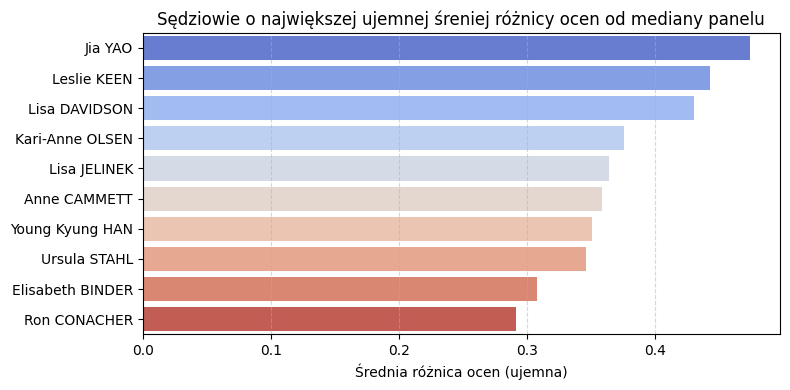

In [18]:
plt.figure(figsize=(8, 4))
sns.barplot(x=judges_lower.values * -1, y=judges_lower.index, palette='coolwarm', hue=judges_lower.index)

plt.title('Sędziowie o największej ujemnej śreniej różnicy ocen od mediany panelu')
plt.ylabel('')
plt.xlabel('Średnia różnica ocen (ujemna)')

plt.tight_layout()
plt.grid(axis='x',  linestyle='--', alpha=0.5)
plt.show()

In [16]:
grouped_same = stats_df.groupby('is_same')['goe_dist'].agg(['mean', 'median', 'std', 'count'])
grouped_same

,mean,median,std,count
is_same,,,,
0,-0.026740,0.0,0.757220,193531
1,0.150236,0.0,0.725521,16088


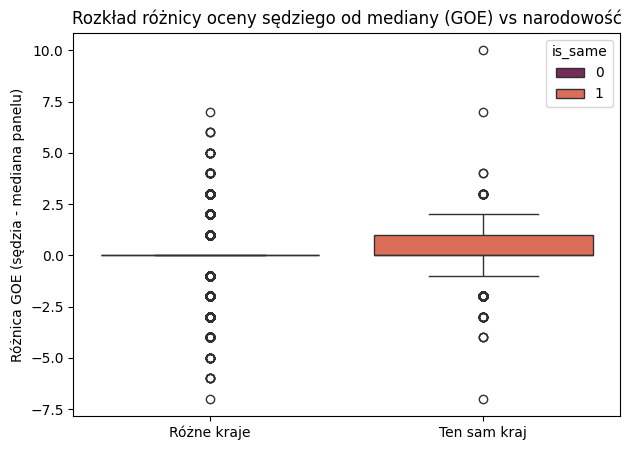

In [23]:
sns.boxplot(x='is_same', y='goe_dist', data=stats_df, palette='rocket', hue='is_same')
plt.xticks([0, 1], ['Różne kraje', 'Ten sam kraj'])
plt.title('Rozkład różnicy oceny sędziego od mediany (GOE) vs narodowość')
plt.xlabel(' ')
plt.ylabel('Różnica GOE (sędzia - mediana panelu)')
plt.tight_layout()
plt.show()

In [28]:
same_country = stats_df[stats_df['is_same'] == 1]

bias_nation = same_country.groupby('judge_nation')['goe_dist'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
bias_nation_f = bias_nation[bias_nation['count'] > 50]

bias_nation_f

,mean,count
judge_nation,,
HKG,0.382716,81
ISR,0.266187,139
UKR,0.264151,53
SWE,0.261111,180
FRA,0.258654,1040
BUL,0.234375,64
RUS,0.231771,1152
KOR,0.230705,1192
GEO,0.208029,274


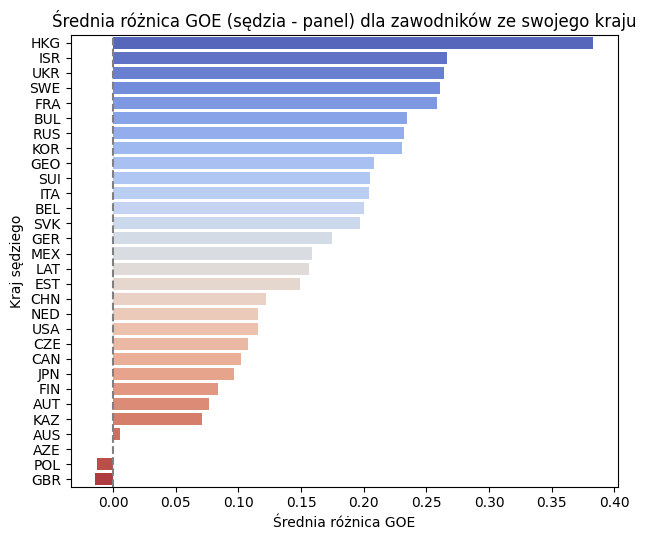

In [47]:
plt.figure(figsize=(6.5, 5.5))
sns.barplot(x=bias_nation_f['mean'], y=bias_nation_f.index, palette='coolwarm', hue=bias_nation_f.index)
plt.title('Średnia różnica GOE (sędzia - panel) dla zawodników ze swojego kraju')
plt.xlabel('Średnia różnica GOE')
plt.ylabel('Kraj sędziego')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()